# Import Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN

In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=FutureWarning, message='use_inf_as_na')

# Data Analysis and Preprocessing

## Initial Analysis

In [3]:
# Load dataset
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [4]:
# Initial exploration
print("Dataset Info:")
df.info()
print("\nFirst 5 rows:")
print(df.head())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-n

## Initial Preprocessing

In [5]:
# Drop customerID
df = df.drop('customerID', axis=1)

In [6]:
# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'], axis=0)  # Drop rows with missing TotalCharges

In [7]:
# Clean PaymentMethod
df["PaymentMethod"] = df["PaymentMethod"].str.replace(" (automatic)", "", regex=False)

In [8]:
# Remove duplicates
df = df.drop_duplicates()

## Outlier Analysis

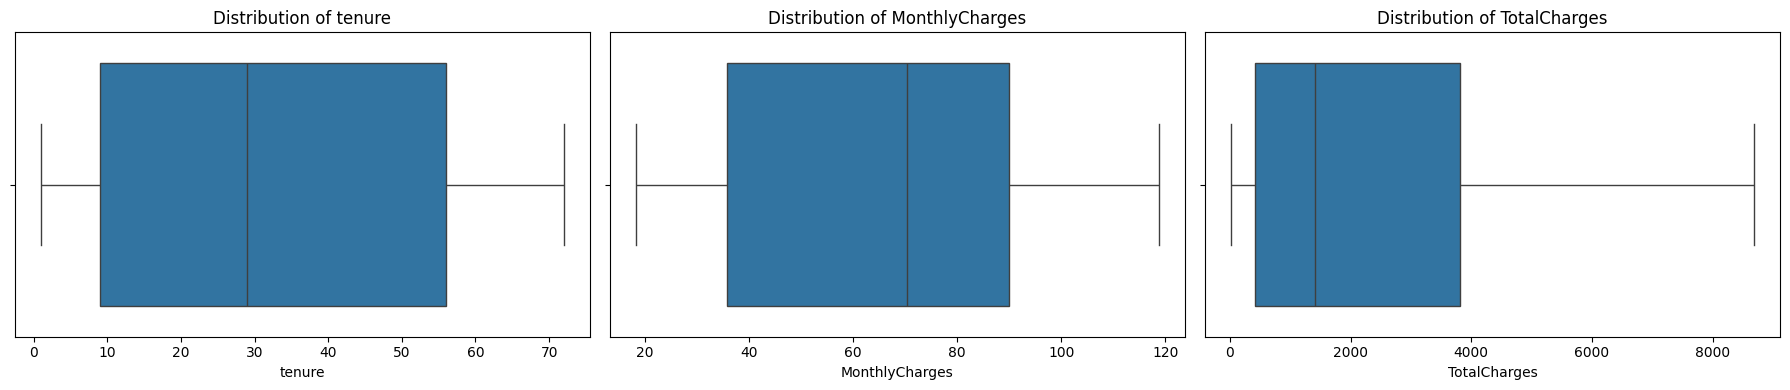

In [9]:
# Outlier analysis
plt.figure(figsize=(18, 4))
for i, col in enumerate(['tenure', 'MonthlyCharges', 'TotalCharges'], 1):
    plt.subplot(1, 3, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## EDA

### Churn Distribution

<ipython-input-10-24b9ddd5a2c1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["Churn"], palette="viridis")


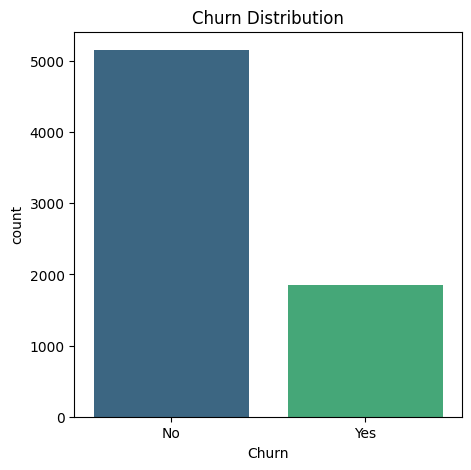

In [10]:
plt.figure(figsize=(5, 5))
sns.countplot(x=df["Churn"], palette="viridis")
plt.title("Churn Distribution")
plt.show()

### Feature-specific Churn Analysis

In [11]:
features = ['InternetService', 'TechSupport', 'OnlineBackup', 'OnlineSecurity',
            'DeviceProtection', 'Contract', 'PaymentMethod', 'PaperlessBilling']

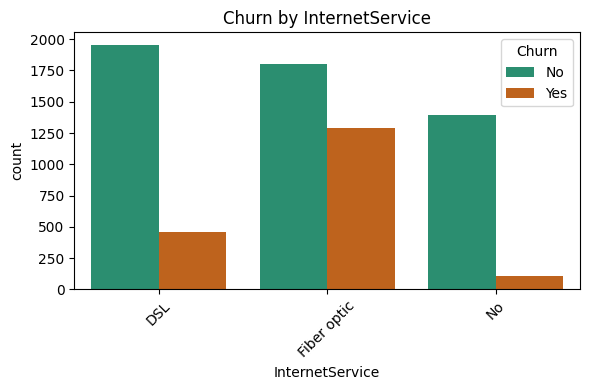

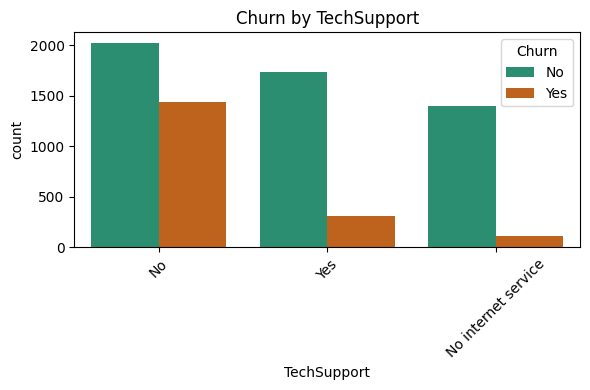

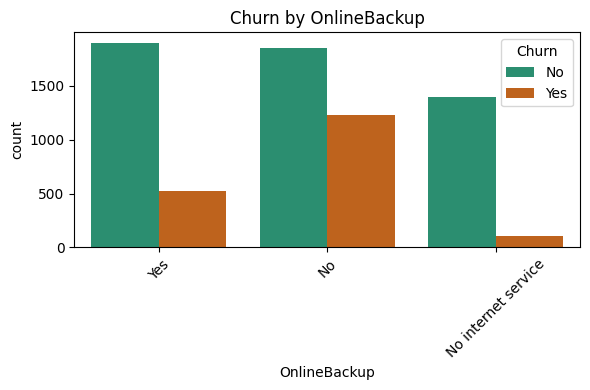

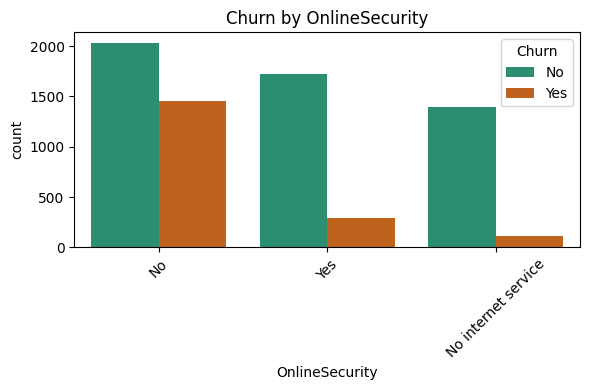

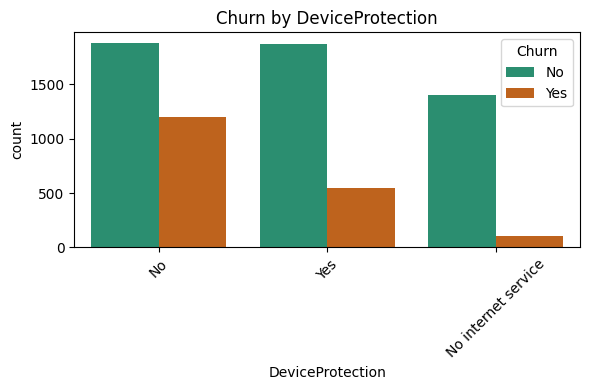

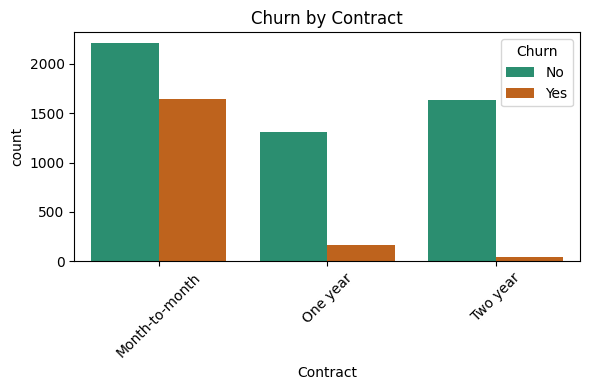

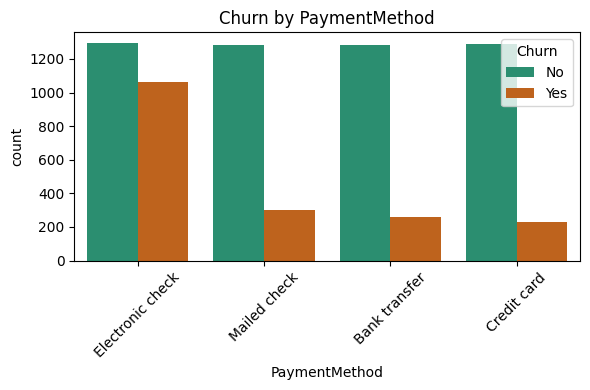

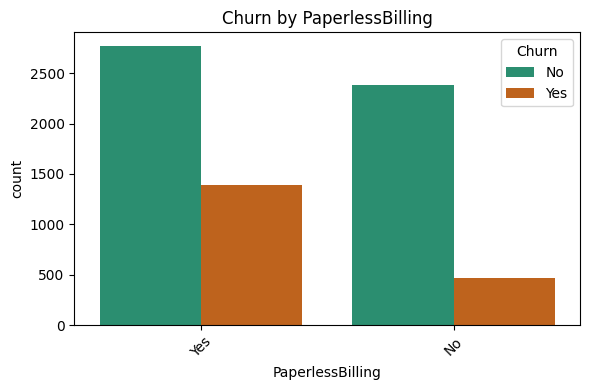

In [13]:
for feature in features:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=feature, hue="Churn", palette="Dark2")
    plt.title(f"Churn by {feature}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Tenure Analysis

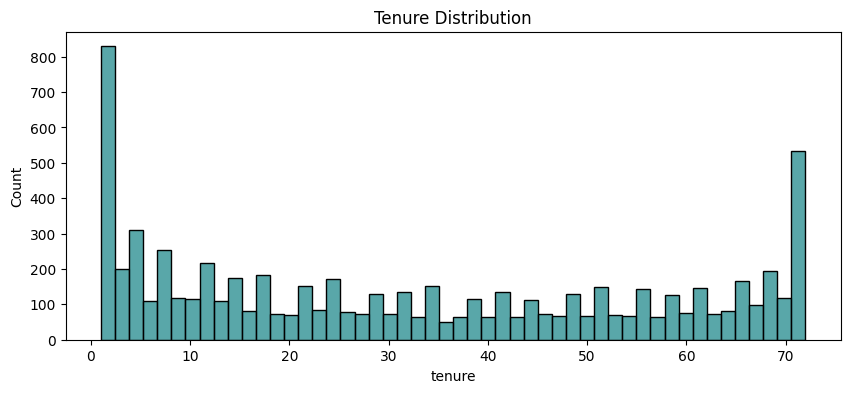

In [14]:
plt.figure(figsize=(10, 4))
sns.histplot(data=df, x="tenure", bins=50, color="#228A8D")
plt.title("Tenure Distribution")
plt.show()

<Figure size 1000x300 with 0 Axes>

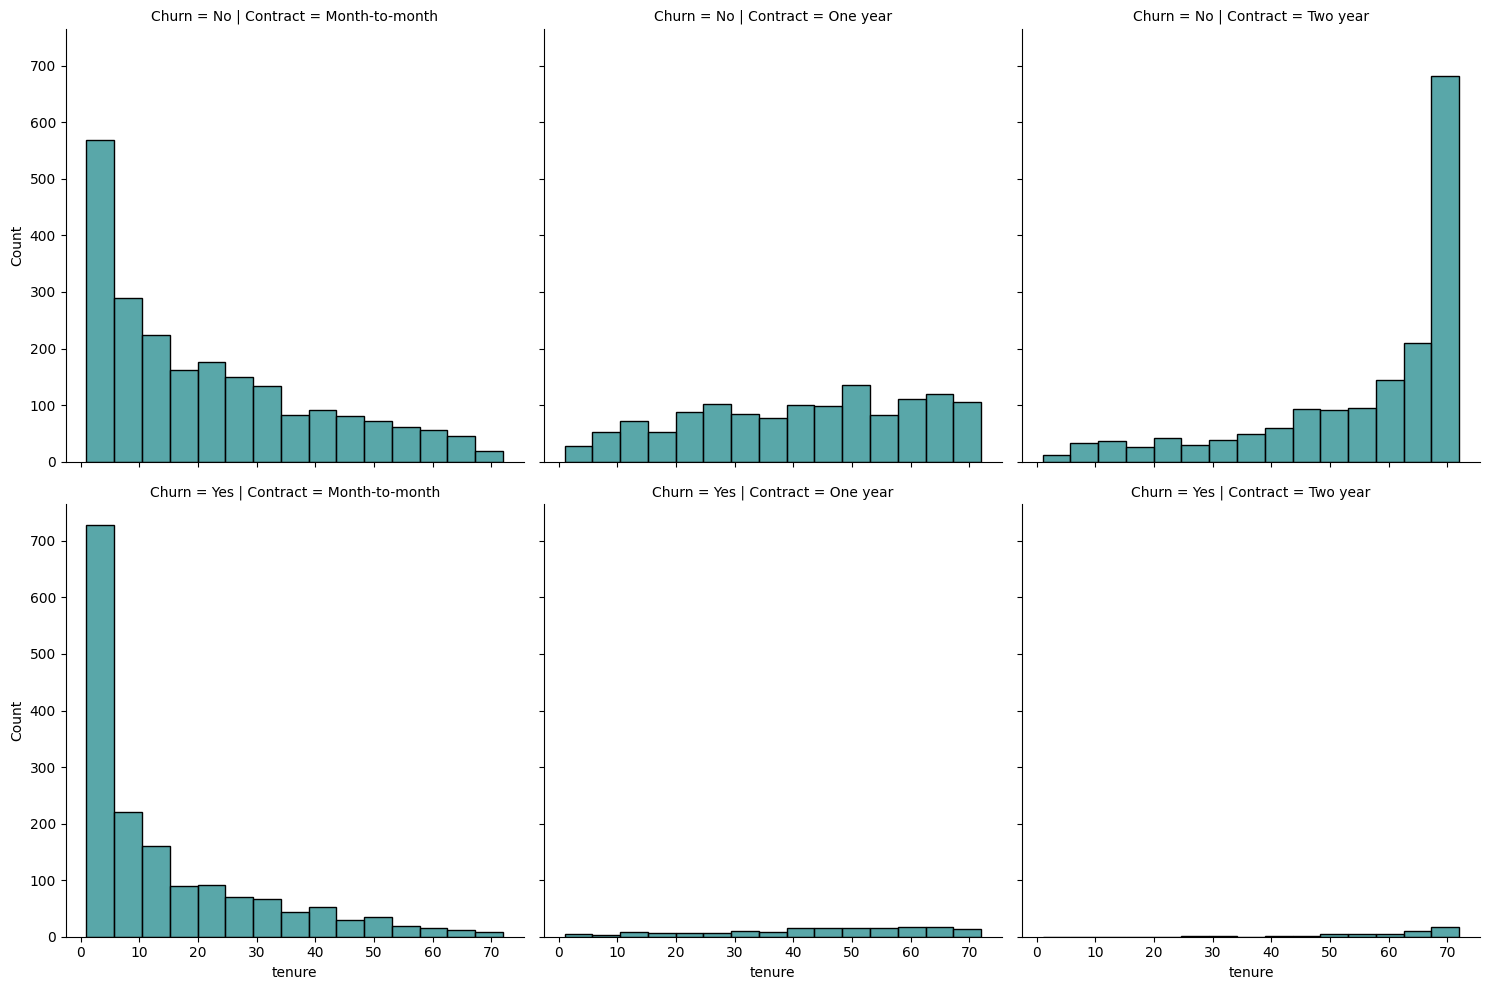

In [15]:
plt.figure(figsize=(10, 3))
sns.displot(data=df, x='tenure', col='Contract', row='Churn', color="#228A8D")
plt.show()

### MonthlyCharges vs TotalCharges

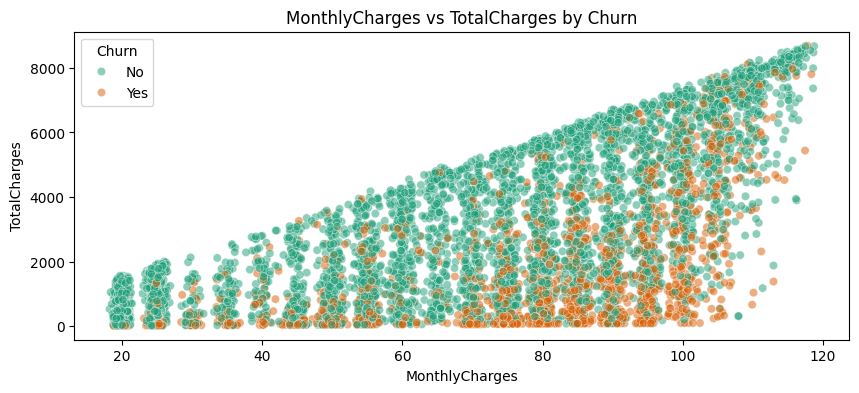

In [16]:
plt.figure(figsize=(10, 4))
sns.scatterplot(data=df, x='MonthlyCharges', y='TotalCharges', hue='Churn', linewidth=0.5, alpha=0.5, palette='Dark2')
plt.title("MonthlyCharges vs TotalCharges by Churn")
plt.show()

### Churn Rate by Tenure

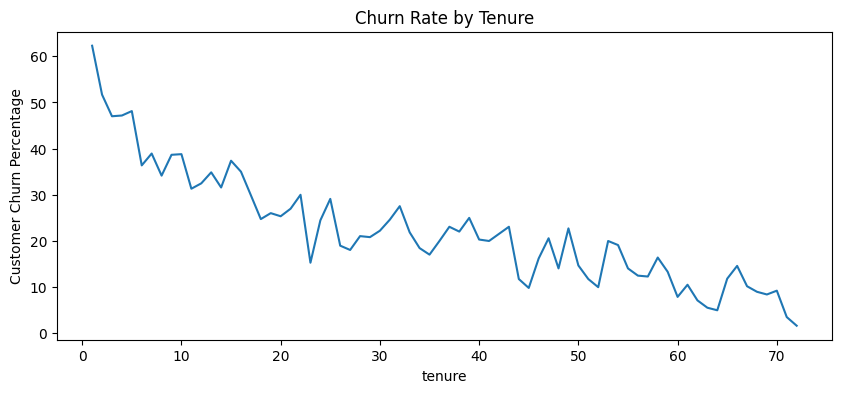

In [17]:
churn_count = df.groupby(['Churn', 'tenure']).count()
churn_yes = churn_count.loc['Yes']
churn_no = churn_count.loc['No']
churn_rate = (churn_yes / (churn_yes + churn_no)) * 100
plt.figure(figsize=(10, 4))
churn_rate["gender"].plot()
plt.ylabel('Customer Churn Percentage')
plt.title("Churn Rate by Tenure")
plt.show()

### Tenure in Years

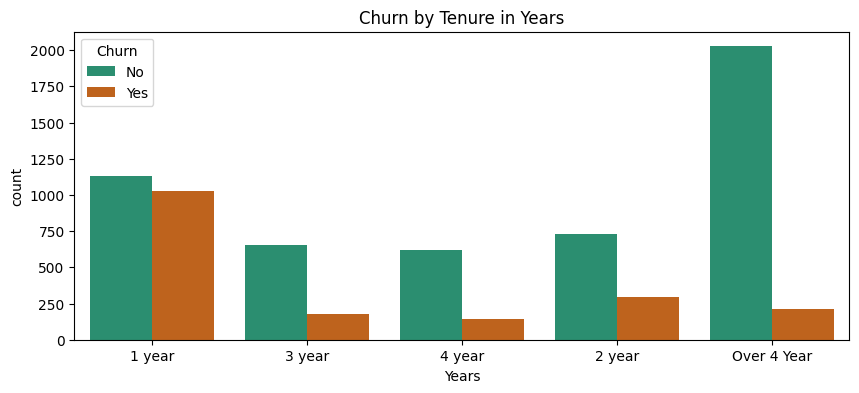

In [18]:
def to_years(tenure):
    if tenure < 13: return '1 year'
    elif tenure < 25: return '2 year'
    elif tenure < 37: return '3 year'
    elif tenure < 49: return '4 year'
    else: return "Over 4 Year"

df['Years'] = df['tenure'].apply(to_years)
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Years', hue='Churn', palette='Dark2')
plt.title("Churn by Tenure in Years")
plt.show()
df = df.drop("Years", axis=1)

## Data Transformation: Encode binary categorical columns

In [19]:
for col in df.columns:
    if df[col].dtype == 'object' and df[col].nunique() == 2 and set(df[col].unique()) == {'No', 'Yes'}:
        df[col] = df[col].map({'No': 0, 'Yes': 1})
        print(f"Encoded binary column: {col}")

Encoded binary column: Partner
Encoded binary column: Dependents
Encoded binary column: PhoneService
Encoded binary column: PaperlessBilling
Encoded binary column: Churn


## Feature Engineering: One-hot encoding for nominal categorical columns

In [20]:
categorical_columns = [col for col in df.columns if df[col].dtype == 'object' and df[col].nunique() <= 10]
df = pd.get_dummies(df, columns=categorical_columns)
for col in df.columns:
    if df[col].nunique() == 2 and df[col].dtype == bool:
        df[col] = df[col].astype(int)

## Data Scaling

In [21]:
scaler = StandardScaler()
numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

## Separate Features and Target

In [22]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

## Handle Class Imbalance with SMOTEENN

In [23]:
sm = SMOTEENN(random_state=101)
X_resampled, y_resampled = sm.fit_resample(X, y)

## Save Preprocessed Data

In [24]:
X_resampled.to_csv("/content/X_preprocessed.csv", index=False)
y_resampled.to_csv("/content/y_preprocessed.csv", index=False)
print("Preprocessed data saved as X_preprocessed.csv and y_preprocessed.csv")

Preprocessed data saved as X_preprocessed.csv and y_preprocessed.csv
